### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- Exploratory Data Analysis (this notebook)
- [Modeling](./03_modeling.ipynb)
- [Experiments](./03a_experiments.ipynb)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find:**
- Baseline accuracy
- TODO etc.

**Model 1: Base feature set - New York**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%store -r ny_df

In [3]:
#Based on a quick review of the stats we can see the average ages and distribution of ages at release which mainly range between 26 and 44 years old.
#We can also see the data spans release years between 2008 and 2015
ny_df.describe()

,Release Year,Age at Release,recidivism,gender_map
count,188650.000000,188650.000000,188650.000000,188650.000000
mean,2011.326064,35.473400,0.416894,0.937228
std,2.289170,10.972873,0.493046,0.242554
min,2008.000000,16.000000,0.000000,0.000000
25%,2009.000000,26.000000,0.000000,1.000000
50%,2011.000000,34.000000,0.000000,1.000000
75%,2013.000000,44.000000,1.000000,1.000000
max,2015.000000,100.000000,1.000000,1.000000


##### Baseline

In [8]:
#Breakdown of Return Status: For modeling I will combine returned parole violation and returned new felony as these both represent recidivism
ny_df['Return Status'].value_counts(normalize = True)

Not Returned                 0.583106
Returned Parole Violation    0.325370
New Felony Offense           0.091524
Name: Return Status, dtype: float64

In [6]:
#Baseline Metrics for Model Evaluation: Majority Class, Not Returned, represents 58% of the observations which will serve as the baseline model accuracy
ny_df['recidivism'].value_counts(normalize = True)

0    0.583106
1    0.416894
Name: recidivism, dtype: float64

##### Age at Release

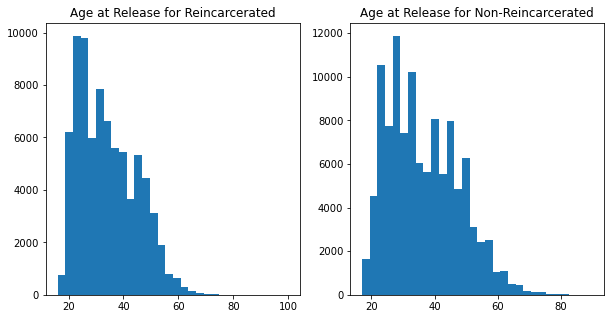

In [11]:
#Distribution of the Age at Release is pretty similar between those who are reincarcerated and those who are not with reincarcerated trending slightly lower in age.
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(ny_df[ny_df['recidivism'] == 1]['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Reincarcerated')
ax[1].hist(ny_df[ny_df['recidivism'] == 0]['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Non-Reincarcerated');

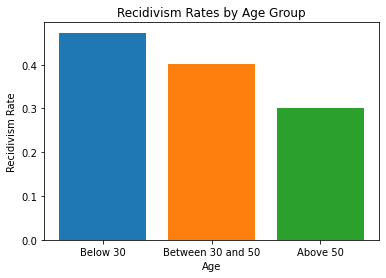

In [12]:
#split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = ny_df[ny_df['Age at Release'] < 30]
between_30_50 = ny_df[(ny_df['Age at Release'] >= 30) & (ny_df['Age at Release'] <= 50)]
above50 = ny_df[ny_df['Age at Release'] > 50]

#calculate recidivism rate for each age group as recidivism = reincarcerated / total pop
below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

#Here we can see a steady decline in recidivism rates as the age at release increases. 
plt.bar(x = 'Below 30', height= below30_recid_rate)
plt.bar(x = 'Between 30 and 50', height = between_30_50_recid_rate)
plt.bar(x = 'Above 50', height = above_50_recid_rate)
plt.xlabel('Age')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Age Group');

##### Gender

In [13]:
male = ny_df[ny_df['Gender'] == 'MALE']
female = ny_df[ny_df['Gender'] == 'FEMALE']

In [14]:
#Males represent an overwhelming ~94% of the observations as such it may be difficult to draw accurate comparisons with only ~12k female observations v. 176k males. 
print(f'Count of Female Observations: {female.shape[0]}')
print(f'Count of Male Observations: {male.shape[0]}')
ny_df['Gender'].value_counts(normalize = True)

Count of Female Observations: 11842
Count of Male Observations: 176808


MALE      0.937228
FEMALE    0.062772
Name: Gender, dtype: float64

In [15]:
male.describe() 

,Release Year,Age at Release,recidivism,gender_map
count,176808.000000,176808.000000,176808.000000,176808.0
mean,2011.327734,35.376476,0.425145,1.0
std,2.286653,11.000085,0.494366,0.0
min,2008.000000,16.000000,0.000000,1.0
25%,2009.000000,26.000000,0.000000,1.0
50%,2011.000000,33.000000,0.000000,1.0
75%,2013.000000,44.000000,1.000000,1.0
max,2015.000000,100.000000,1.000000,1.0


In [16]:
female.describe()

,Release Year,Age at Release,recidivism,gender_map
count,11842.000000,11842.000000,11842.000000,11842.0
mean,2011.301132,36.920537,0.293700,0.0
std,2.326383,10.452333,0.455476,0.0
min,2008.000000,17.000000,0.000000,0.0
25%,2009.000000,28.000000,0.000000,0.0
50%,2011.000000,36.000000,0.000000,0.0
75%,2013.000000,45.000000,1.000000,0.0
max,2015.000000,86.000000,1.000000,0.0


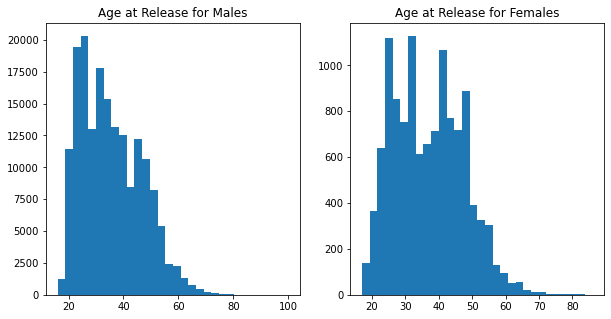

In [17]:
#The distrubtion of age at release is slightly lower for men as oppossed to women. Avg age at release for women is 37 versus 35 for men.
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(male['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Males')
ax[1].hist(female['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Females');

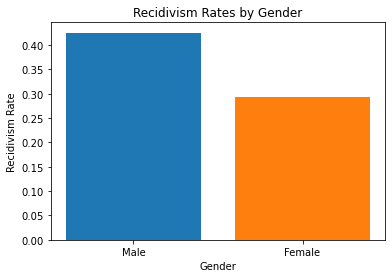

In [18]:
#Men have a 13% higher recidivism rate then women. 
plt.bar(x = 'Male', height= male[male['recidivism'] == 1]['recidivism'].value_counts() / male.shape[0])
plt.bar(x = 'Female', height = female[female['recidivism'] == 1]['recidivism'].value_counts() / female.shape[0])
plt.xlabel('Gender')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Gender');

##### County of Indictment

In [19]:
#There are 63 different counties of indictment however ~80% of observations come from 15 counties.
ny_df['County of Indictment'].value_counts(normalize = True)[:15]

NEW YORK       0.182067
KINGS          0.104394
BRONX          0.094355
QUEENS         0.070167
SUFFOLK        0.049632
MONROE         0.045460
ERIE           0.043615
ONONDAGA       0.033485
NASSAU         0.031625
ALBANY         0.031248
WESTCHESTER    0.023393
ORANGE         0.023096
ONEIDA         0.018669
BROOME         0.015823
SCHENECTADY    0.014583
Name: County of Indictment, dtype: float64

In [20]:
#Recidivism Rates by County of Indictment (showing the top 15 recidivism rates per county)
ny_df.groupby(['County of Indictment'])['recidivism'].mean().sort_values(ascending = False)[:15]

County of Indictment
MONROE         0.525770
ERIE           0.505105
SCHENECTADY    0.504907
CHEMUNG        0.501913
BROOME         0.497822
TOMPKINS       0.497630
CHAUTAUQUA     0.491356
TIOGA          0.485043
RENSSELAER     0.483302
CORTLAND       0.482866
ULSTER         0.482848
ONONDAGA       0.481716
SENECA         0.477663
ALBANY         0.475997
OSWEGO         0.474727
Name: recidivism, dtype: float64

In [21]:
%store ny_df

Stored 'ny_df' (DataFrame)


**Model 2: Criminal history feature set - Florida**

**Model 3: Behavioral feature set - Georgia**

**Combined/Summary Visualizations**

**FINAL NOTES:**
- All visualizations from this EDA exercise can be found in the **visualizations** directory.
- There is no data output from this notebook.
- The next notebook in the series is [Modeling](./03_modeling.ipynb).